In [83]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn import decomposition
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from joblib import parallel_backend
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import statsmodels.api as sm
random.seed(42) 

In [46]:
import warnings
warnings.filterwarnings('ignore') 

In [20]:
train = pd.read_csv('heart_train.csv')
train.drop(['id'], axis=1, inplace=True)

In [21]:
train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,64,0,4,180,325,0,0,154,1,0.0,1,0,3,0
1,61,1,4,120,260,0,0,140,1,3.6,2,1,7,1
2,52,0,3,136,196,0,2,169,0,0.1,2,0,3,0
3,62,0,4,160,164,0,2,145,0,6.2,3,3,7,1
4,69,1,1,160,234,1,2,131,0,0.1,2,1,3,0


In [22]:
train.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
count,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000
mean,55.030837,0.674009,3.167401,131.585903,247.070485,0.136564,0.995595,149.911894,0.317181,0.997357,1.603524,0.458150
std,8.842972,0.469780,0.953890,17.465145,52.573626,0.344145,0.997775,23.333314,0.466407,1.149141,0.618008,0.499347
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,49.500000,0.000000,3.000000,120.000000,212.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,240.000000,0.000000,1.000000,154.000000,0.000000,0.600000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,273.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,192.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [23]:
train.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

# Correlation Heatmap

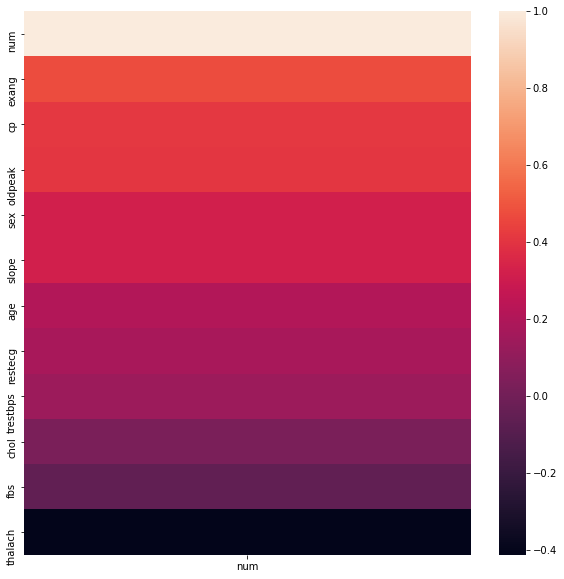

age         0.207218
sex         0.318831
cp          0.414221
trestbps    0.135499
chol        0.026575
fbs        -0.056714
restecg     0.172806
thalach    -0.412741
exang       0.475219
oldpeak     0.406952
slope       0.318788
num         1.000000
Name: num, dtype: float64

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr()[['num']].sort_values(by=['num'], ascending=False))
plt.show()
train.corr()['num']

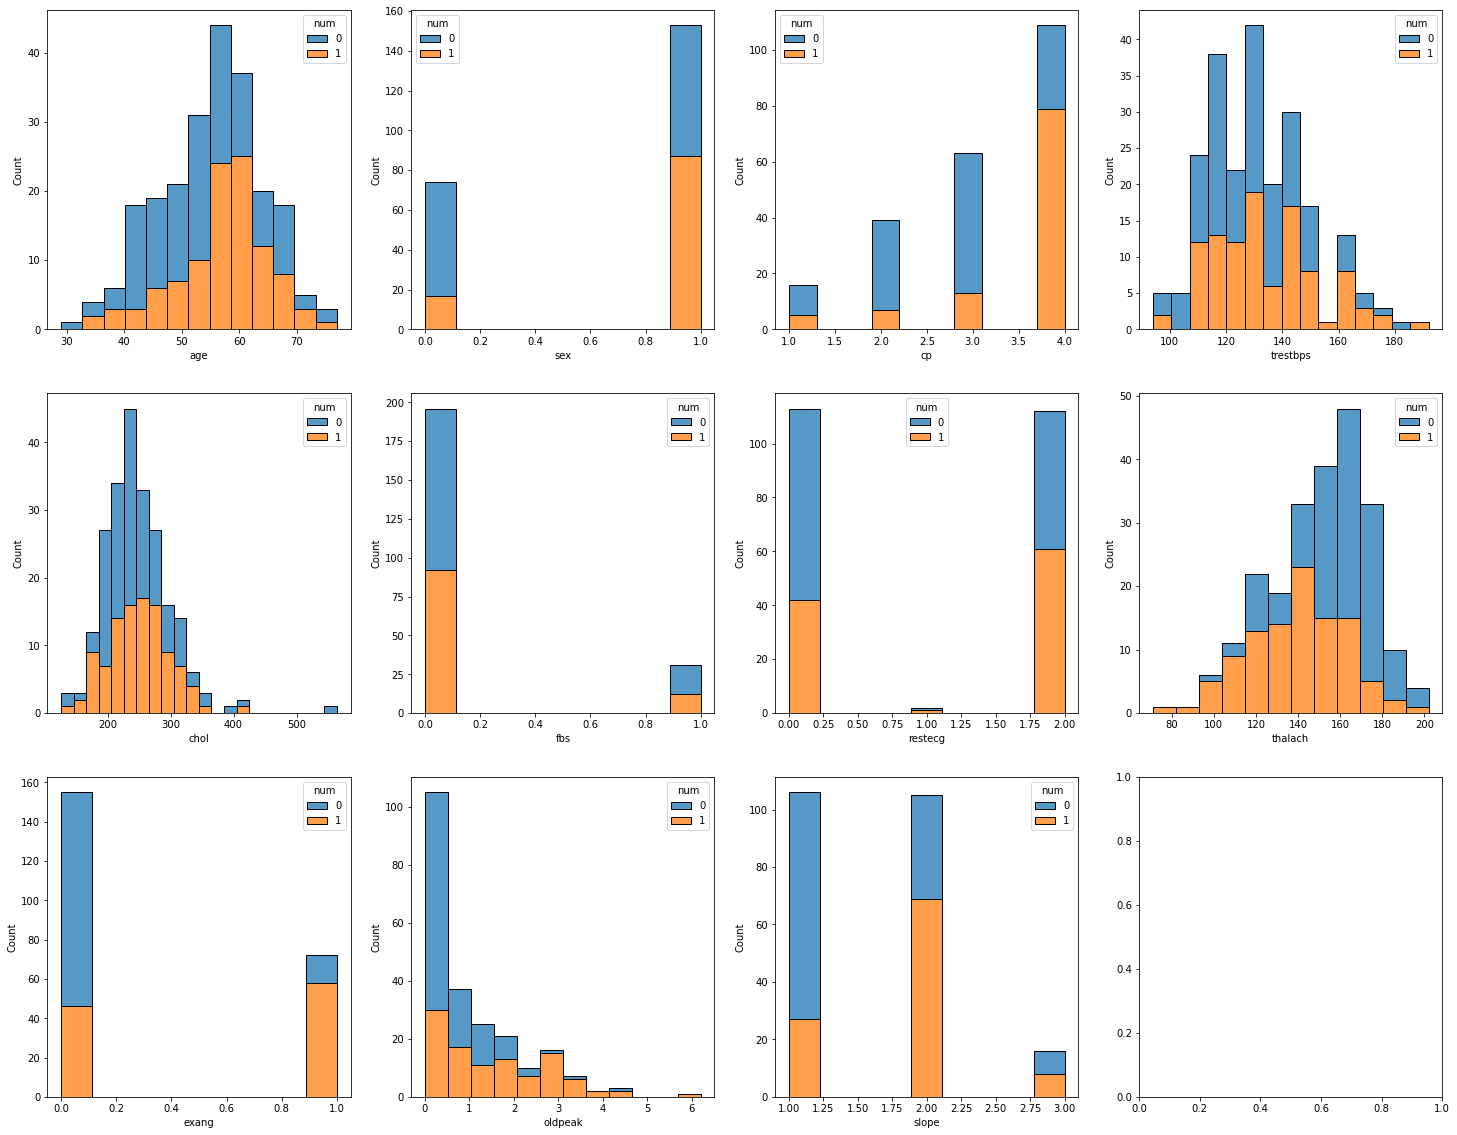

In [25]:
fig, ax = plt.subplots(3,4,figsize=(25,20))
ax = ax.flatten()
for i in range(11):
    sns.histplot(x=train.iloc[:,i], hue = train['num'], ax=ax[i], multiple="stack")
plt.show()

# No Signs of Multicollinearity based on graphs below

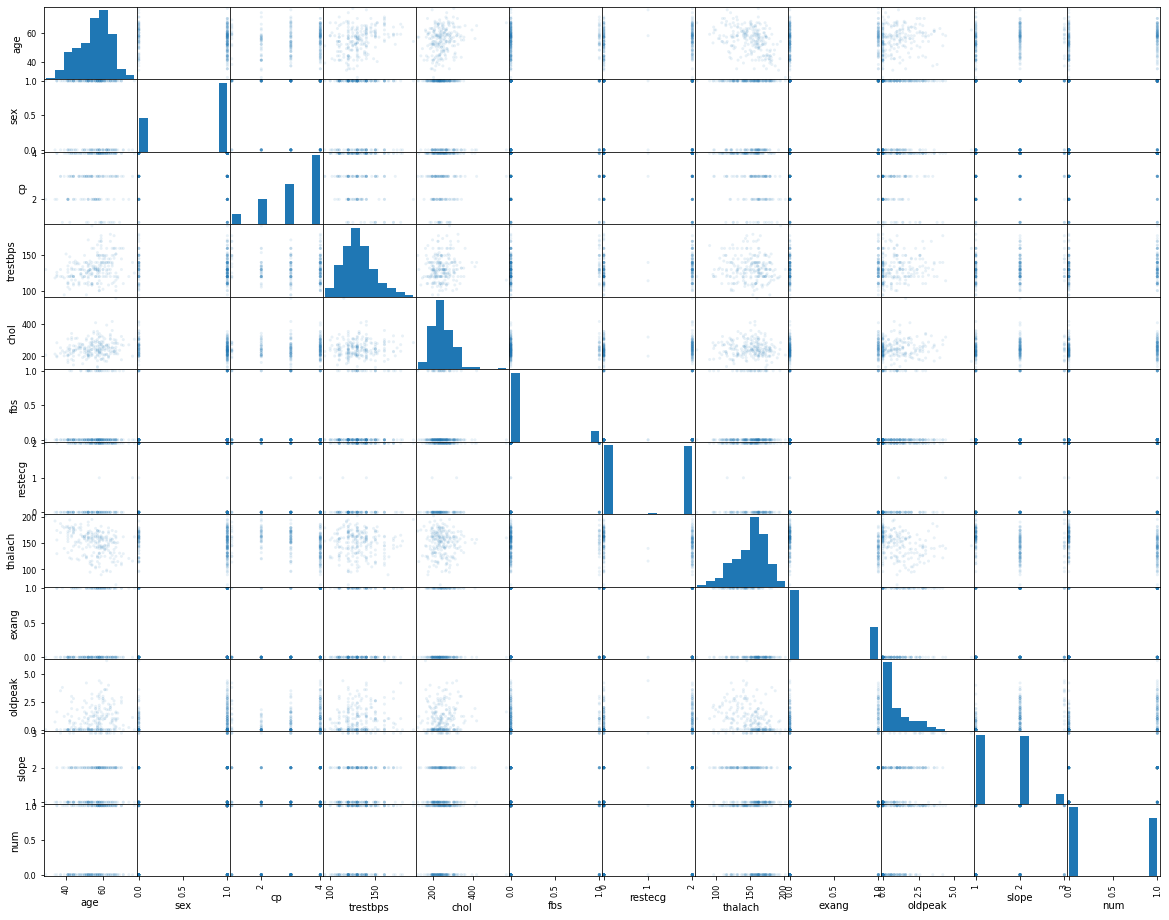

In [26]:
attributes = train.columns
scatter_matrix(train[attributes], figsize=(20, 16), alpha=0.1)
plt.show()

# Imputation, Augmentation, and Pipelining

In [27]:
stroke = train['num']
train.drop(['num'], axis=1, inplace=True)

In [28]:
train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,64,0,4,180,325,0,0,154,1,0.0,1,0,3
1,61,1,4,120,260,0,0,140,1,3.6,2,1,7
2,52,0,3,136,196,0,2,169,0,0.1,2,0,3
3,62,0,4,160,164,0,2,145,0,6.2,3,3,7
4,69,1,1,160,234,1,2,131,0,0.1,2,1,3


In [32]:
num_pipeline = Pipeline([
        ('std_scaler', MinMaxScaler())
    ])

categorical_features = ["cp", "restecg", "slope", "ca", "thal"]
numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])

In [33]:
train_prepared = full_pipeline.fit_transform(train)

In [34]:
train_prepared

array([[0.72916667, 0.87755102, 0.4543379 , ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.26530612, 0.30593607, ..., 0.        , 1.        ,
        0.        ],
       [0.47916667, 0.42857143, 0.15981735, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.6875    , 0.46938776, 0.32420091, ..., 0.        , 0.        ,
        0.        ],
       [0.64583333, 0.36734694, 0.1826484 , ..., 0.        , 1.        ,
        0.        ],
       [0.64583333, 0.57142857, 0.30136986, ..., 0.        , 1.        ,
        0.        ]])

# Logistic Regression

In [86]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score)}

In [87]:
logit = LogisticRegression()

In [88]:
stratified_KFold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [89]:
logit_result = cross_validate(logit, train_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [90]:
print("Logistic Accuracy: ", logit_result['test_accuracy'].mean())
print("Logistic Precision: ", logit_result['test_precision'].mean())
print("Logistic Recall: ", logit_result['test_recall'].mean())
print("Logistic F1: ", logit_result['test_f1_score'].mean())
print("Logistic AUROC: ", logit_result['test_roc_auc'].mean())

Logistic Accuracy:  0.8059903381642511
Logistic Precision:  0.832112332112332
Logistic Recall:  0.74
Logistic F1:  0.7761643060187293
Logistic AUROC:  0.8003333333333333


# KNN

In [91]:
KNN = KNeighborsClassifier(n_neighbors=5)

In [92]:
KNN_results = cross_validate(KNN, train_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [93]:
print("KNN Accuracy: ", KNN_results['test_accuracy'].mean())
print("KNN Precision: ", KNN_results['test_precision'].mean())
print("KNN Recall: ", KNN_results['test_recall'].mean())
print("KNN F1: ", KNN_results['test_f1_score'].mean())
print("KNN AUROC: ", KNN_results['test_roc_auc'].mean())

KNN Accuracy:  0.81487922705314
KNN Precision:  0.8378258145363409
KNN Recall:  0.7395238095238096
KNN F1:  0.783554216237143
KNN AUROC:  0.8085952380952381


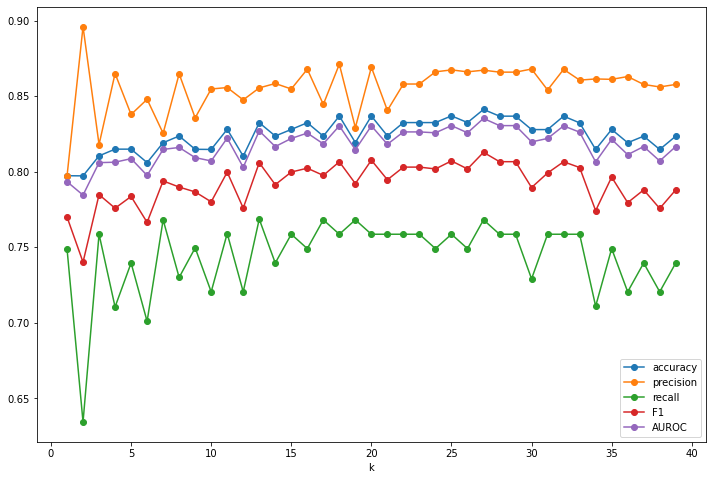

In [94]:
recall_scores = []
accuracy_scores = []
precision_scores = []
F1_scores = []
AUROC_scores = []

ks = [i for i in range(1,40)]
for k in ks:
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN_results = cross_validate(KNN, train_prepared, stroke, cv=stratified_KFold, scoring=scoring)
    
    accuracy = KNN_results['test_accuracy'].mean()
    accuracy_scores.append(accuracy)
    
    precision = KNN_results['test_precision'].mean()
    precision_scores.append(precision)
    
    recall = KNN_results['test_recall'].mean()
    recall_scores.append(recall)
    
    F1 = KNN_results['test_f1_score'].mean()
    F1_scores.append(F1)
    
    AUROC = KNN_results['test_roc_auc'].mean()
    AUROC_scores.append(AUROC)

plt.figure(figsize=(12,8))
plt.plot(ks, accuracy_scores, 'o-', label='accuracy')
plt.plot(ks, precision_scores, 'o-', label='precision')
plt.plot(ks, recall_scores, 'o-', label='recall')
plt.plot(ks, F1_scores, 'o-', label='F1')
plt.plot(ks, AUROC_scores, 'o-', label='AUROC')
plt.xlabel('k')
plt.legend()
plt.show()

# SVM

In [95]:
SVM = SVC()

In [96]:
SVM_results = cross_validate(SVM, train_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [97]:
print("SVM Accuracy: ", SVM_results['test_accuracy'].mean())
print("SVM Precision: ", SVM_results['test_precision'].mean())
print("SVM Recall: ", SVM_results['test_recall'].mean())
print("SVM F1: ", SVM_results['test_f1_score'].mean())
print("SVM AUROC: ", SVM_results['test_roc_auc'].mean())

SVM Accuracy:  0.8235748792270531
SVM Precision:  0.8430903461863213
SVM Recall:  0.759047619047619
SVM F1:  0.7973856230771774
SVM AUROC:  0.8181904761904762


In [98]:
rbf_SVM = SVC(kernel='rbf', class_weight='balanced')

In [99]:
rbf_SVM_results = cross_validate(rbf_SVM, train_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [100]:
print("rbf SVM Accuracy: ", rbf_SVM_results['test_accuracy'].mean())
print("rbf SVM Precision: ", rbf_SVM_results['test_precision'].mean())
print("rbf SVM Recall: ", rbf_SVM_results['test_recall'].mean())
print("rbf SVM F1: ", rbf_SVM_results['test_f1_score'].mean())
print("rbf SVM AUROC: ", rbf_SVM_results['test_roc_auc'].mean())

rbf SVM Accuracy:  0.823671497584541
rbf SVM Precision:  0.8211353948694102
rbf SVM Recall:  0.7876190476190474
rbf SVM F1:  0.8019179713450842
rbf SVM AUROC:  0.8204761904761906


In [101]:
Linear_SVM = SVC(kernel='linear', class_weight='balanced')

In [102]:
Linear_SVM_results = cross_validate(Linear_SVM, train_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [103]:
print("Linear SVM Accuracy: ", Linear_SVM_results['test_accuracy'].mean())
print("Linear SVM Precision: ", Linear_SVM_results['test_precision'].mean())
print("Linear SVM Recall: ", Linear_SVM_results['test_recall'].mean())
print("Linear SVM F1: ", Linear_SVM_results['test_f1_score'].mean())
print("Linear SVM AUROC: ", Linear_SVM_results['test_roc_auc'].mean())

Linear SVM Accuracy:  0.81487922705314
Linear SVM Precision:  0.8461988304093566
Linear SVM Recall:  0.7304761904761904
Linear SVM F1:  0.7807750144592249
Linear SVM AUROC:  0.8080714285714287


# Decision Tree

In [104]:
dt = DecisionTreeClassifier(random_state=42)

In [105]:
dt_results = cross_validate(dt, train_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [106]:
print("DT Accuracy: ", dt_results['test_accuracy'].mean())
print("DT Precision: ", dt_results['test_precision'].mean())
print("DT Recall: ", dt_results['test_recall'].mean())
print("DT F1: ", dt_results['test_f1_score'].mean())
print("DT AUROC: ", dt_results['test_roc_auc'].mean())

DT Accuracy:  0.682512077294686
DT Precision:  0.6718851674641149
DT Recall:  0.6161904761904762
DT F1:  0.6311594202898552
DT AUROC:  0.6784285714285714


# Random Forest

In [107]:
random_forest = RandomForestClassifier(random_state=42)

In [108]:
random_forest_results = cross_validate(random_forest, train_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [109]:
print("Random Forest Accuracy: ", random_forest_results['test_accuracy'].mean())
print("Random Forest Precision: ", random_forest_results['test_precision'].mean())
print("Random Forest Recall: ", random_forest_results['test_recall'].mean())
print("Random Forest F1: ", random_forest_results['test_f1_score'].mean())
print("Random Forest AUROC: ", random_forest_results['test_roc_auc'].mean())

Random Forest Accuracy:  0.8016425120772948
Random Forest Precision:  0.8200696035990154
Random Forest Recall:  0.73
Random Forest F1:  0.7689103619336178
Random Forest AUROC:  0.7958333333333334


# AdaBoost

In [110]:
ada_tree = AdaBoostClassifier(n_estimators=10000, learning_rate=0.005, random_state=42)

In [111]:
with parallel_backend('threading', n_jobs=11):
    ada_tree_results = cross_validate(ada_tree, train_prepared, stroke, cv=stratified_KFold, scoring=scoring)

In [112]:
print("Adaboost Tree Accuracy: ", ada_tree_results['test_accuracy'].mean())
print("Adaboost Tree Precision: ", ada_tree_results['test_precision'].mean())
print("Adaboost Tree Recall: ", ada_tree_results['test_recall'].mean())
print("Adaboost Tree F1: ", ada_tree_results['test_f1_score'].mean())
print("Adaboost Tree AUROC: ", ada_tree_results['test_roc_auc'].mean())

Adaboost Tree Accuracy:  0.7485024154589371
Adaboost Tree Precision:  0.7367154517309317
Adaboost Tree Recall:  0.7109523809523809
Adaboost Tree F1:  0.7209343125254997
Adaboost Tree AUROC:  0.7454761904761904
